1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

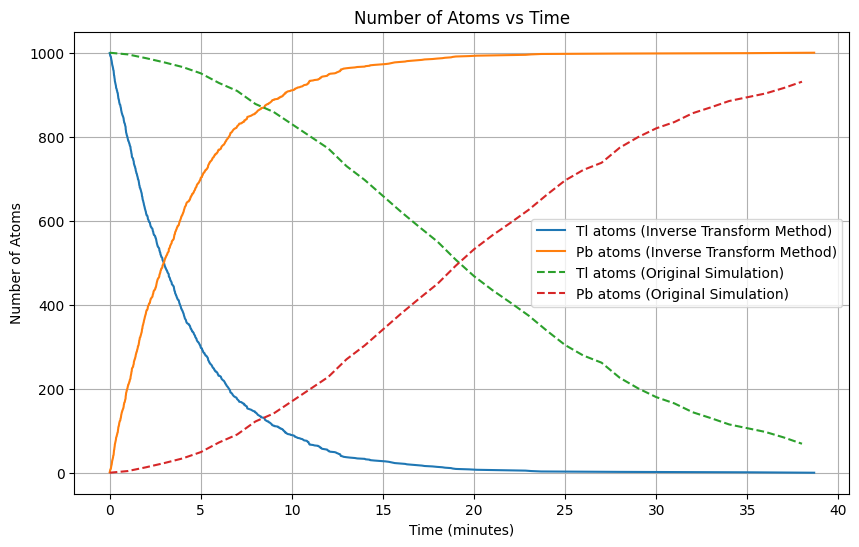

In [1]:
import numpy as np
import matplotlib.pyplot as plt

initial_Tl_atoms = 1000
half_life = 3.052 
decay_constant = np.log(2) / half_life
num_random_numbers = 1000

# Generating random numbers from the non-uniform probability distribution
random_numbers = -np.log(1 - np.random.rand(num_random_numbers)) / decay_constant
random_numbers.sort()

# Calculating the number of Tl and Pb atoms at each time point
remaining_Tl_atoms_inverse_transform = initial_Tl_atoms - np.arange(1, num_random_numbers + 1)
remaining_Pb_atoms_inverse_transform = initial_Tl_atoms - remaining_Tl_atoms_inverse_transform

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(random_numbers, remaining_Tl_atoms_inverse_transform, label='Tl atoms (Inverse Transform Method)')
plt.plot(random_numbers, remaining_Pb_atoms_inverse_transform, label='Pb atoms (Inverse Transform Method)')

# Plot using the original simulation
time_step = 1  # in seconds
total_time_seconds = int(np.ceil(max(random_numbers)))  # adjust total time based on generated random numbers
time_points = np.arange(0, total_time_seconds, time_step)
Tl_atoms = np.zeros(len(time_points))
Pb_atoms = np.zeros(len(time_points))

remaining_Tl_atoms = initial_Tl_atoms
remaining_Pb_atoms = 0

for i, t in enumerate(time_points):
    probability_decay = 1 - 2 ** (-t / (half_life * 60))
    decayed_Tl_atoms = np.random.binomial(remaining_Tl_atoms, probability_decay)
    remaining_Tl_atoms -= decayed_Tl_atoms
    remaining_Pb_atoms += decayed_Tl_atoms
    Tl_atoms[i] = remaining_Tl_atoms
    Pb_atoms[i] = remaining_Pb_atoms

plt.plot(time_points, Tl_atoms, label='Tl atoms (Original Simulation)', linestyle='dashed')
plt.plot(time_points, Pb_atoms, label='Pb atoms (Original Simulation)', linestyle='dashed')

plt.title('Number of Atoms vs Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Number of Atoms')
plt.legend()
plt.grid(True)
plt.show()


2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

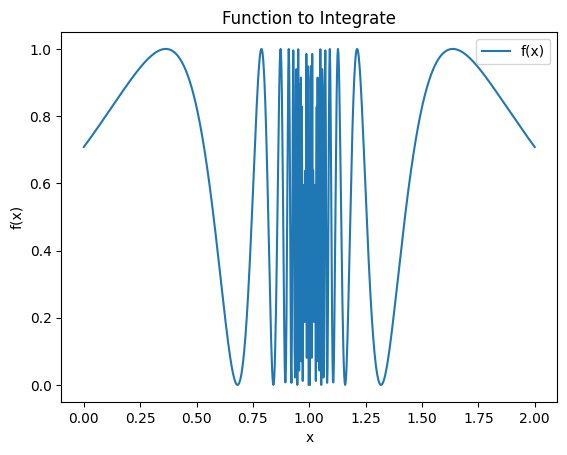

Hit/Miss Method:
Integral Estimate: 1.3624
Error Estimate: 0.009320226606687201

Mean Value Method:
Integral Estimate: 1.3616794800445708
Error Estimate: 0.0064483795728444955


' the mean value method produces a result with a lower error than that of the HIT/MISS method '

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.sin(1 / (1 - x))**2

# Plotting the function
x_values = np.linspace(0, 2, 1000)
plt.plot(x_values, f(x_values), label='f(x)')
plt.title('Function to Integrate')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

a, b = 0, 2 
N = 10000

def hit_miss_integration():
    random_x = np.random.uniform(a, b, N)
    random_y = np.random.uniform(0, 1, N)
    integral_estimate = (b - a) * np.mean(random_y < f(random_x))
    error_estimate = (b - a) * np.std(random_y < f(random_x)) / np.sqrt(N)
    return integral_estimate, error_estimate

def mean_value_integration():
    random_x = np.random.uniform(a, b, N)
    integral_estimate = (b - a) * np.mean(f(random_x))
    error_estimate = (b - a) * np.std(f(random_x)) / np.sqrt(N)
    return integral_estimate, error_estimate

integral_hit_miss, error_hit_miss = hit_miss_integration()
integral_mean_value, error_mean_value = mean_value_integration()

print("Hit/Miss Method:")
print(f"Integral Estimate: {integral_hit_miss}")
print(f"Error Estimate: {error_hit_miss}")

print("\nMean Value Method:")
print(f"Integral Estimate: {integral_mean_value}")
print(f"Error Estimate: {error_mean_value}")

""" the mean value method produces a result with a lower error than that of the HIT/MISS method """

3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [3]:
import numpy as np

N = 100000 

def monte_carlo_for_circle(N):
    random_points = np.random.uniform(-1, 1, size=(N, 2))
    inside_circle = np.sum(random_points[:, 0]**2 + random_points[:, 1]**2 <= 1)
    area_estimate = inside_circle / N * 4 
    return area_estimate

def monte_carlo_for_sphere(N, dimensions):
    random_points = np.random.uniform(-1, 1, size=(N, dimensions))
    inside_sphere = np.sum(np.sum(random_points**2, axis=1) <= 1)
    volume_estimate = inside_sphere / N * (2**dimensions) 
    return volume_estimate

#computing area of a unit circle
print(f"Monte carlo estimate: Area of Unit Circle: {monte_carlo_for_circle(N)}")

#for 10 dimensions
print(f"Monte carlo estimate: 10D Unit Sphere colume: {monte_carlo_for_sphere(N, 10)}")


Monte carlo estimate: Area of Unit Circle: 3.14344
Monte carlo estimate: 10D Unit Sphere colume: 2.3552


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [4]:
import numpy as np
from scipy.integrate import quad

# Define the weight function
def weight_function(x):
    return 1 / np.sqrt(x)

# PDF of the custom distribution
def custom_pdf(x):
    return (1 / normalization_factor) * (1 / (2 * np.sqrt(x)))

# Function to be integrated
def integrand(x):
    return x**(-1/2) / (np.exp(x) + 1)

# Calculate the normalization factor
normalization_factor, _ = quad(weight_function, 0, 1)

# Number of random points to generate
N = 1000

# Generating random points according to the weight function
random_points = np.random.random(N)**2  #Squaring to satisfy w(x) = 1/sqrt(x)

# Calculate the Monte Carlo estimate with proper weight adjustment
integral = np.mean(integrand(random_points) / weight_function(random_points) * normalization_factor)

print(f"Value of the Integral: {integral}")

Value of the Integral: 0.8407970488307729
